In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, mean_squared_error, cohen_kappa_score, classification_report
)

In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/train"
TEST_DIR  = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/test"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128,128),
    batch_size=64,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128,128),
    batch_size=64,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(128,128),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

Found 10627 images belonging to 10 classes.
Found 2653 images belonging to 10 classes.
Found 1929 images belonging to 10 classes.


In [ ]:
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


In [ ]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128,128,3)
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4421s 26s/step - accuracy: 0.6339 - loss: 1.0730 - val_accuracy: 0.8232 - val_loss: 0.5023
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 554s 3s/step - accuracy: 0.8528 - loss: 0.4492 - val_accuracy: 0.8541 - val_loss: 0.4113
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - accuracy: 0.8871 - loss: 0.3274 - val_accuracy: 0.8899 - val_loss: 0.3231
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 519s 3s/step - accuracy: 0.9029 - loss: 0.2812 - val_accuracy: 0.8982 - val_loss: 0.2996
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 508s 3s/step - accuracy: 0.9122 - loss: 0.2523 - val_accuracy: 0.8967 - val_loss: 0.2863
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 523s 3s/step - accuracy: 0.9247 - loss: 0.2089 - val_accuracy: 0.9133 - val_loss: 0.2512
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.9323 - loss: 0.1889 - val_accuracy: 0.9235 - val_loss: 0.2266
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.9389 - loss: 0.1783 - val_ac

In [ ]:
history_2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    initial_epoch=10,
    verbose=1
)

Epoch 11/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.9742 - loss: 0.0746 - val_accuracy: 0.9442 - val_loss: 0.1636
Epoch 12/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.9740 - loss: 0.0767 - val_accuracy: 0.9389 - val_loss: 0.1827
Epoch 13/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.9769 - loss: 0.0658 - val_accuracy: 0.9450 - val_loss: 0.1682
Epoch 14/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 504s 3s/step - accuracy: 0.9746 - loss: 0.0726 - val_accuracy: 0.9453 - val_loss: 0.1734
Epoch 15/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.9760 - loss: 0.0676 - val_accuracy: 0.9435 - val_loss: 0.1813
Epoch 16/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.9772 - loss: 0.0655 - val_accuracy: 0.9461 - val_loss: 0.1727
Epoch 17/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 552s 3s/step - accuracy: 0.9748 - loss: 0.0700 - val_accuracy: 0.9423 - val_loss: 0.1748
Epoch 18/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 515s 3s/step - accuracy: 0.9748 - loss: 0.0669 - 

In [ ]:
model.save("/content/drive/MyDrive/rice_leaf_mobilenetv2.h5")

In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print("\nTest Loss     :", test_loss)
print("Test Accuracy :", test_accuracy)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 553s 18s/step - accuracy: 0.8927 - loss: 0.3614

Test Loss     : 0.2189992219209671
Test Accuracy : 0.9315707683563232


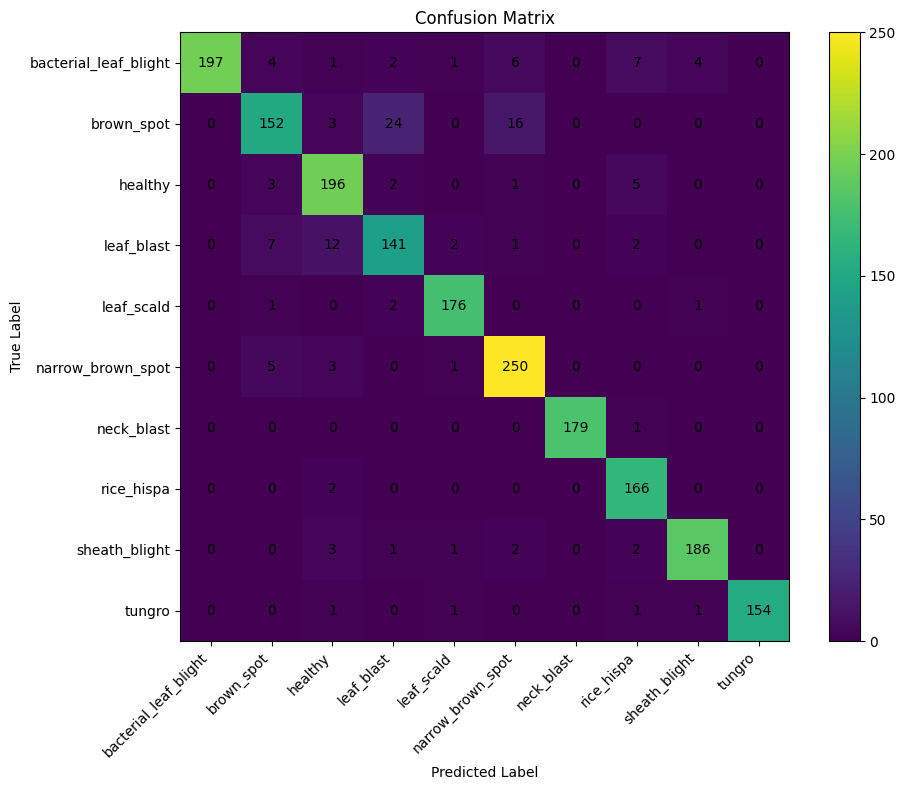

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(np.arange(len(class_names)), class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import math
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, mean_squared_error, cohen_kappa_score, classification_report
)
import matplotlib.pyplot as plt

steps = math.ceil(test_gen.samples / test_gen.batch_size)
y_pred_prob = model.predict(test_gen, steps=steps, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes

print("y_true:", len(y_true))
print("y_pred:", len(y_pred))

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall    = recall_score(y_true, y_pred, average="weighted")
f1        = f1_score(y_true, y_pred, average="weighted")
mse       = mean_squared_error(y_true, y_pred)
kappa     = cohen_kappa_score(y_true, y_pred)

print("\n=== MODEL PERFORMANCE METRICS ===")
print("Accuracy   :", accuracy)
print("Precision  :", precision)
print("Recall     :", recall)
print("F1-Score   :", f1)
print("MSE        :", mse)
print("Kappa      :", kappa)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


31/31 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step
y_true: 1929
y_pred: 1929

=== MODEL PERFORMANCE METRICS ===
Accuracy   : 0.9315707620528771
Precision  : 0.9332865580311903
Recall     : 0.9315707620528771
F1-Score   : 0.9312561612470758
MSE        : 0.9315707620528771
Kappa      : 0.9237753001653648

Classification Report:

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.89      0.94       222
           brown_spot       0.88      0.78      0.83       195
              healthy       0.89      0.95      0.92       207
           leaf_blast       0.82      0.85      0.84       165
           leaf_scald       0.97      0.98      0.97       180
    narrow_brown_spot       0.91      0.97      0.93       259
           neck_blast       1.00      0.99      1.00       180
           rice_hispa       0.90      0.99      0.94       168
        sheath_blight       0.97      0.95      0.96       195
               tungro       1.00      0.97      0.99

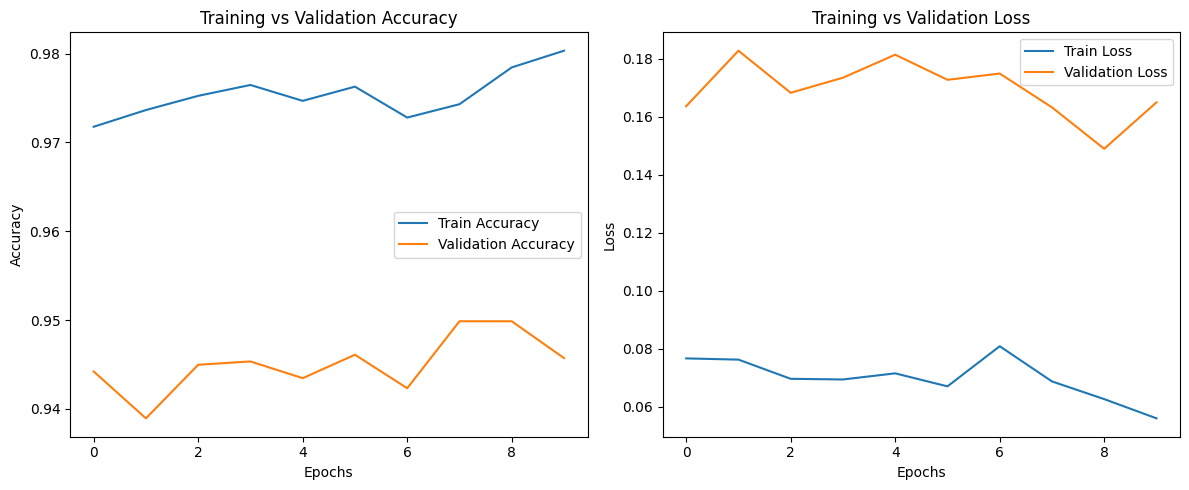

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_2.history["accuracy"], label="Train Accuracy")
plt.plot(history_2.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_2.history["loss"], label="Train Loss")
plt.plot(history_2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

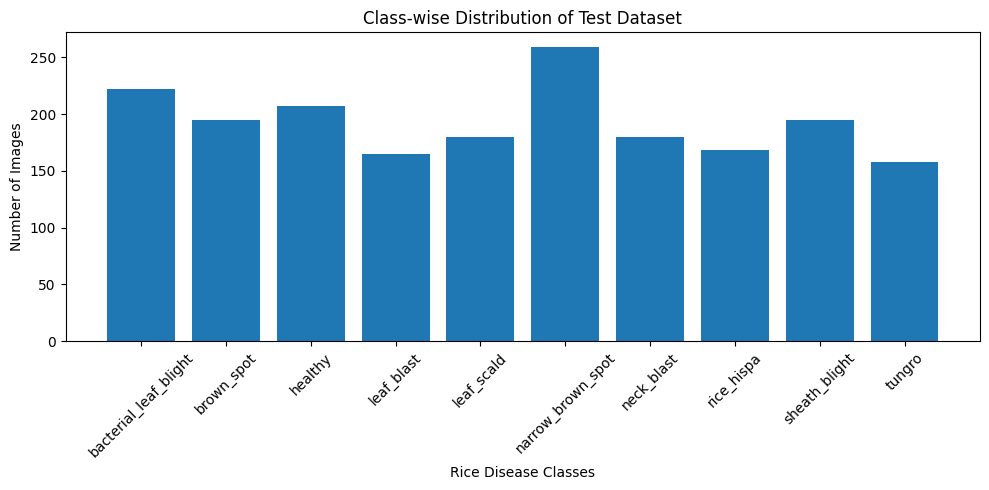

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

class_counts = pd.Series(test_gen.classes).value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.bar(class_names, class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Rice Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class-wise Distribution of Test Dataset")
plt.tight_layout()
plt.show()


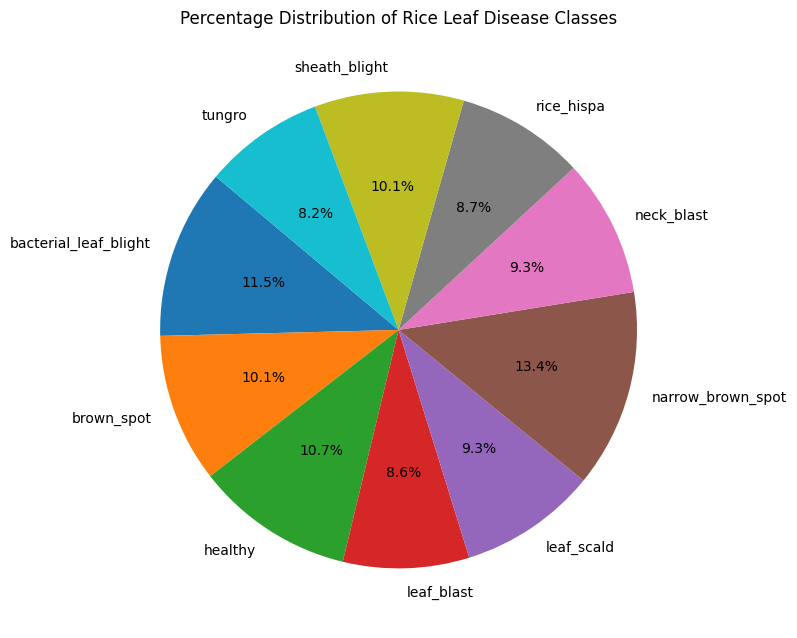

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(
    class_counts.values,
    labels=class_names,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Percentage Distribution of Rice Leaf Disease Classes")
plt.tight_layout()
plt.show()


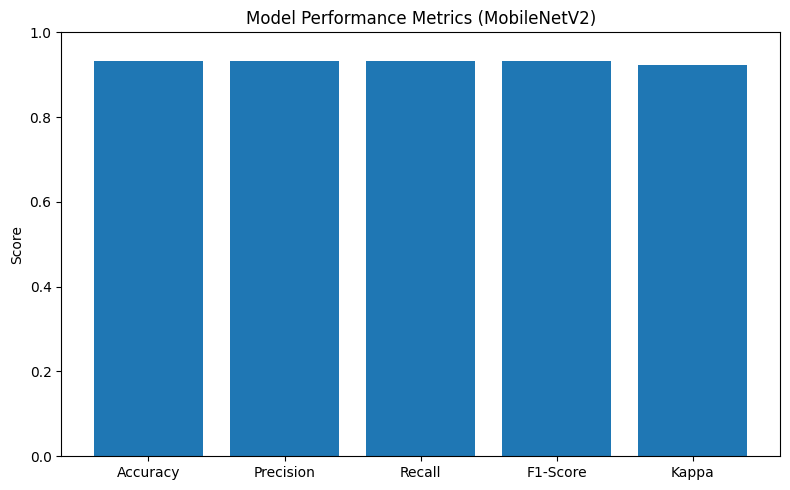

In [ ]:
metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score", "Kappa"]
metrics_values = [accuracy, precision, recall, f1, kappa]

plt.figure(figsize=(8,5))
plt.bar(metrics_names, metrics_values)
plt.ylim(0,1)
plt.title("Model Performance Metrics (MobileNetV2)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


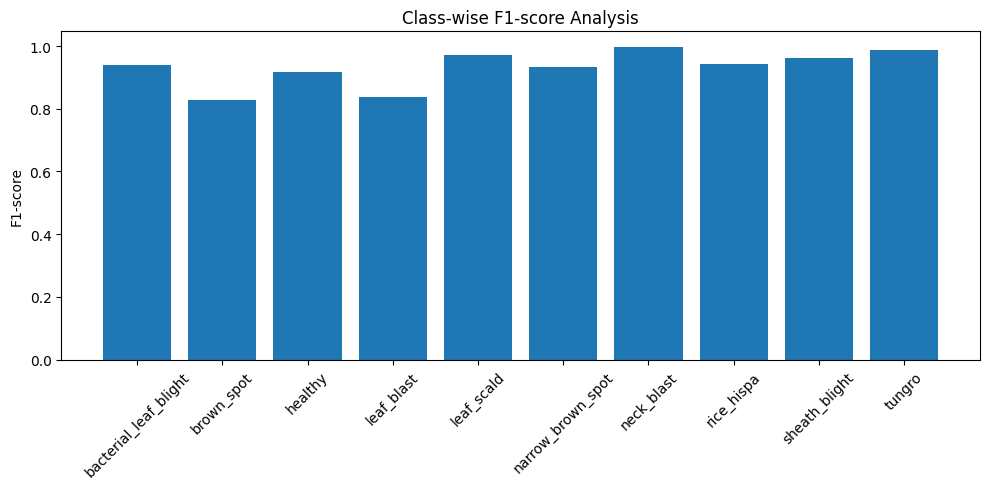

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)

f1_scores = [report[c]["f1-score"] for c in class_names]

plt.figure(figsize=(10,5))
plt.bar(class_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel("F1-score")
plt.title("Class-wise F1-score Analysis")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

 Predicted Class: class_6

Class Probabilities:
class_0: 0.00%
class_1: 0.00%
class_2: 0.00%
class_3: 0.00%
class_4: 0.00%
class_5: 0.00%
class_6: 100.00%
class_7: 0.00%
class_8: 0.00%
class_9: 0.00%

Using last convolutional layer for Grad-CAM: Conv_1


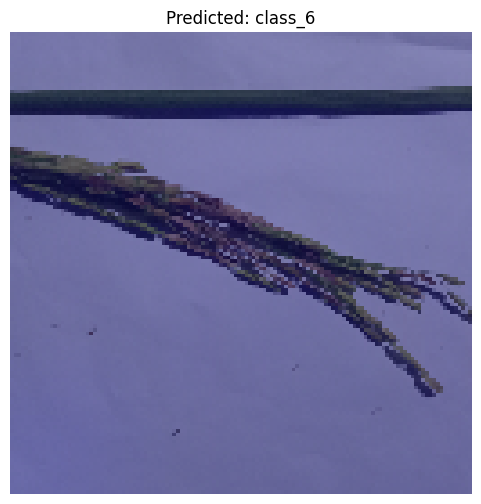

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

class_names = [
    'bacterial_leaf_blight',
    'brown_spot',
    'leaf_smut',
    'neck_blast',
    'healthy',
    'tungro',
    'other_disease',
    'another_class'
]

img_path = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/test/neck_blast/IMG20201109211732_00.jpg"
img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0

preds = model.predict(img_array)
class_index = int(np.argmax(preds[0]))
num_classes = preds.shape[1]

if len(class_names) != num_classes:
    class_names = [f"class_{i}" for i in range(num_classes)]

predicted_class_name = class_names[class_index]
print(f"\n Predicted Class: {predicted_class_name}\n")

print("Class Probabilities:")
for i, name in enumerate(class_names):
    print(f"{name}: {preds[0][i]*100:.2f}%")

for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print(f"\nUsing last convolutional layer for Grad-CAM: {last_conv_layer_name}")

def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return heatmap

heatmap = get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name)

img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (128,128))

heatmap_resized = cv2.resize(heatmap, (128,128))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Predicted: {predicted_class_name}")
plt.show()


In [ ]:

import json
from tensorflow.keras.models import load_model

MODEL_PATH = "/content/drive/MyDrive/rice_leaf_mobilenetv2.keras"
CLASS_NAMES_PATH = "/content/drive/MyDrive/rice_leaf_class_names.json"

model.save(MODEL_PATH)
print(" Model saved successfully at:", MODEL_PATH)

with open(CLASS_NAMES_PATH, "w") as f:
    json.dump(class_names, f)
print(" Class names saved successfully at:", CLASS_NAMES_PATH)

 Model saved successfully at: /content/drive/MyDrive/rice_leaf_mobilenetv2.keras
 Class names saved successfully at: /content/drive/MyDrive/rice_leaf_class_names.json
